# Theory

In [1]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


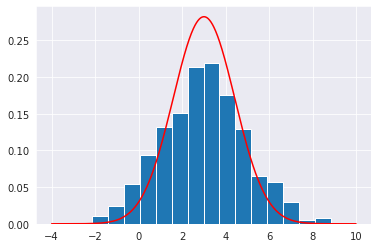

In [2]:
# set the random seed
rng = np.random.default_rng(42)
# generate a sample of normally distributed random variables with mean mu and variance var
mu = 3
var = 2
# generate a random sample using the numpy function
sample = rng.normal(mu, var, 500)

def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

In [3]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = params
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, 'Mean value: $\\mu$')

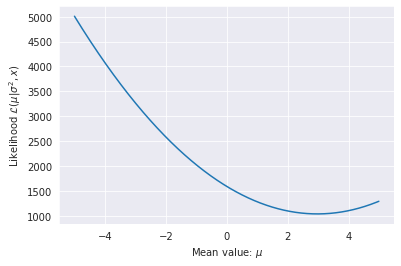

In [10]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Minimising the likelihood function using scipy.optimize.minimize

In [11]:
initial_guess = rng.random()

lik_model = minimize(likelihood, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 26
         Function evaluations: 52


array([2.97374745])

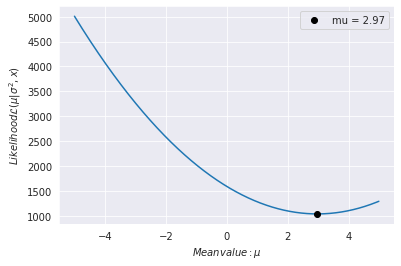

In [12]:
plt.plot(mu, likelihood_values)
plt.ylabel("$Likelihood \mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("$Mean value: \mu$")
plt.plot(lik_model.x, lik_model.fun, 'ko', label=f"mu = {lik_model.x[0]:.2f}")
plt.legend()

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = ax^{2} + bx^{2}$

In [25]:
def model(params, x):
    a, b = params
    return a*x**2 + np.exp(x)

In [26]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

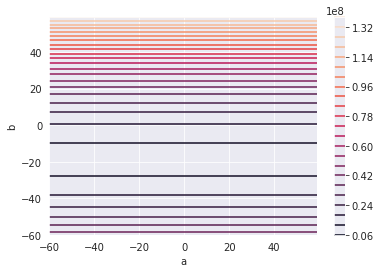

In [27]:
a = np.arange(-60, 60, 1)
b = np.arange(-60, 60, 1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.colorbar()

In [30]:
class Simulator:
    def __init__(self, objective):
        self.objective = objective # actual objective function
        self.call_count = 0 # how many times the objective function has been called
        self.callback_count = 0 # number of times callback has been called, also measures iteration count
        self.list_calls_inp = [] # input of all calls
        self.list_calls_res = [] # result of all calls
        self.decreasing_list_calls_inp = [] # input of calls that resulted in decrease
        self.decreasing_list_calls_res = [] # result of calls that resulted in decrease
        self.list_callback_inp = [] # only appends inputs on callback, as such they correspond to the iterations
        self.list_callback_res = [] # only appends results on callback, as such they correspond to the iterations

    def simulate(self, x, *args):
        """
            Executes the simulation.
            Returns the result and updates the lists for the callback.
            Pass to the optimiser as the 
        """
        result = self.objective(x, *args)
        if not self.call_count: # first call is stored in all lists
            self.decreasing_list_calls_inp.append(x)
            self.decreasing_list_calls_res.append(result)
            self.list_callback_inp.append(x)
            self.list_callback_res.append(result)
        elif result < self.decreasing_list_calls_res[-1]:
            self.decreasing_list_calls_inp.append(x)
            self.decreasing_list_calls_res.append(result)
        self.list_calls_inp.append(x)
        self.list_calls_res.append(result)
        self.call_count += 1
        return result
    
    def callback(self, xk, *_):
        s1 = ""
        xk = np.atleast_1d(xk)
        for i, x in reversed(list(enumerate(self.list_calls_inp))):
            x = np.atleast_1d(x)
            if np.allclose(x, xk):
                break

        for comp in xk:
            s1 += f"{comp:10.5e}\t"
        s1 += f"{self.list_calls_res[i]:10.5e}"

        self.list_callback_inp.append(xk)
        self.list_callback_res.append(self.list_calls_res[i])

        if not self.callback_count:
            s0 = ""
            for j, _ in enumerate(xk):
                tmp = f"Comp-{j+1}"
                s0 += f"{tmp:10s}\t"
            s0 += "Objective"
            print(s0)
        print(s1)
        self.callback_count += 1

        
likelihood_sim = Simulator(likelihood)
minimize(likelihood_sim.simulate, x0=initial_guess, args=sample, method="Nelder-Mead",
         callback=likelihood_sim.callback, options={"disp": True})

Comp-1    	Comp-2    	Objective
1.07705e-01	3.92288e-01	1.76443e+07
1.07705e-01	3.92288e-01	1.76443e+07
8.37708e-02	4.19657e-01	1.76261e+07
8.37708e-02	4.19657e-01	1.76261e+07
3.59018e-02	5.01764e-01	1.75897e+07
3.59018e-02	5.01764e-01	1.75897e+07
-5.98363e-02	6.38609e-01	1.75172e+07
-5.98363e-02	6.38609e-01	1.75172e+07
-2.51312e-01	9.39667e-01	1.73734e+07
-2.51312e-01	9.39667e-01	1.73734e+07
-6.34265e-01	1.51442e+00	1.70902e+07
-6.34265e-01	1.51442e+00	1.70902e+07
-1.40017e+00	2.69128e+00	1.65415e+07
-1.40017e+00	2.69128e+00	1.65415e+07
-2.93198e+00	5.01764e+00	1.55146e+07
-2.93198e+00	5.01764e+00	1.55146e+07
-5.99560e+00	9.69773e+00	1.37435e+07
-5.99560e+00	9.69773e+00	1.37435e+07
-1.21228e+01	1.90305e+01	1.13314e+07
-1.51864e+01	2.37334e+01	1.06905e+07
-2.13137e+01	3.30663e+01	1.05388e+07
-2.13137e+01	3.30663e+01	1.05388e+07
-1.82501e+01	2.84044e+01	1.04263e+07
-1.82501e+01	2.84044e+01	1.04263e+07
-1.82501e+01	2.84044e+01	1.04263e+07
-1.90160e+01	2.95630e+01	1.04191e+07
-1.90160e+01

 final_simplex: (array([[-18.86664787,  29.35760321],
       [-18.86664787,  29.35753194],
       [-18.86664787,  29.35756758]]), array([10418661.53282958, 10418661.53282958, 10418661.53282959]))
           fun: 10418661.532829579
       message: 'Optimization terminated successfully.'
          nfev: 143
           nit: 73
        status: 0
       success: True
             x: array([-18.86664787,  29.35760321])

In [16]:
initial_guess = rng.random(2)

print(initial_guess)

def callback_function(Xi):
    global nfev
    print(f"{nfev}, {Xi[0]}, {Xi[1]}")
    Nfeval += 1

lik_model = minimize(likelihood, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     callback=callback_function,
                     options={"disp": True})

lik_model.x

[0.11967256 0.36491936]
Optimization terminated successfully.
         Current function value: 893.249084
         Iterations: 56
         Function evaluations: 113


array([0.13940925, 0.04673377])

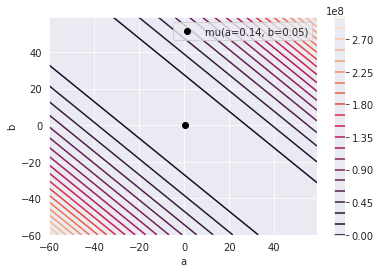

In [17]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("b")
plt.xlabel("a")
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()